# Convolutions for Images

In [41]:
import torch
from torch import nn
from d2l import torch as d2l

## The Cross - Correlation operation

We can imagine the kernel as a sliding window over the image input. The output will have size\
$$(n_h - k_h + 1) \cdot (n_w - k_w + 1)$$

In [42]:
def corr2d(X, K):       #@save
    '''Compute 2D cross-correlation'''
    h, w = K.shape
    Y = torch.zeros((X.shape[0] - h + 1, X.shape[1] - w + 1))
    for i in range(Y.shape[0]):
        for j in range(Y.shape[1]):
            Y[i, j] = (X[i:i + h, j:j+w] * K).sum()

    return Y

In [43]:
X = torch.tensor([[0.0, 1.0, 2.0], [3.0, 4.0, 5.0], [6.0, 7.0, 8.0]])
K = torch.tensor([[0.0, 1.0], [2.0, 3.0]])
corr2d(X, K)

tensor([[19., 25.],
        [37., 43.]])

## Convolutional Layers

We employ random initialization as usual.

In [44]:
class Conv2D(nn.Module):
    def __init__(self, kernel_size):
        super().__init__()
        self.weight = nn.Parameter(torch.rand(kernel_size))
        self.bias = nn.Parameter(torch.zeros(1))

    def forward(self, x):
        return corr2d(x, self.weight) + self.bias

To refer to the kernel dimension, we can say "$h \times w$ convolutional layer"

## Object Edge Detection in Images

We just need to find the location of the pixel change.

In [45]:
X = torch.ones((6, 8))
X[:, 2:6] = 0
X

tensor([[1., 1., 0., 0., 0., 0., 1., 1.],
        [1., 1., 0., 0., 0., 0., 1., 1.],
        [1., 1., 0., 0., 0., 0., 1., 1.],
        [1., 1., 0., 0., 0., 0., 1., 1.],
        [1., 1., 0., 0., 0., 0., 1., 1.],
        [1., 1., 0., 0., 0., 0., 1., 1.]])

The following kernel is based on the principle that
$$x_{i, j} - x_{i, j+1}$$

is 0 if they are in the same shape and 1 if there is an edge.\
Note how this is an approximation of the first order derivative.

In [46]:
K = torch.tensor([[1.0, -1.0]])
Y = corr2d(X, K)
Y

tensor([[ 0.,  1.,  0.,  0.,  0., -1.,  0.],
        [ 0.,  1.,  0.,  0.,  0., -1.,  0.],
        [ 0.,  1.,  0.,  0.,  0., -1.,  0.],
        [ 0.,  1.,  0.,  0.,  0., -1.,  0.],
        [ 0.,  1.,  0.,  0.,  0., -1.,  0.],
        [ 0.,  1.,  0.,  0.,  0., -1.,  0.]])

In [47]:
# Note how it detects only vertical edges

corr2d(X.t(), K)

tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])

## Learning a Kernel

In [48]:
# Construct a two-dimensional convolutional layer with 1 output channel,
# a kernel of shape (1, 2). For the sake of simplicity, we ignore the bias.

conv2d = nn.LazyConv2d(1, kernel_size=(1, 2), bias = False)

# The two-dimensional convolutional layer uses four-dimensional input and
# output in the format of (example, channel, height, width), where the batch
# size (number of examples in the batch) and the number of channels are both 1

X = X.reshape((1, 1, 6, 8))
Y = Y.reshape((1, 1, 6, 7))
lr = 3e-2 

for i in range(10):
    Y_hat = conv2d(X)
    l = (Y_hat - Y) ** 2
    conv2d.zero_grad()
    l.sum().backward()
    #Update the kernel
    conv2d.weight.data[:] -= lr * conv2d.weight.grad
    if (i + 1) % 2 == 0:
        print(f'epoch {i + 1}, loss {l.sum(): .3f}')

epoch 2, loss  3.316
epoch 4, loss  0.841
epoch 6, loss  0.258
epoch 8, loss  0.091
epoch 10, loss  0.035


/home/pachy/.cache/pypoetry/virtualenvs/dive_into_deep_learning-88_68WVw-py3.10/lib/python3.10/site-packages/torch/nn/modules/lazy.py:181: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


In [49]:
conv2d.weight.data.reshape((1, 2))

tensor([[ 0.9736, -1.0112]])

## Feature Map and Receptive Field

The output of a convolution is called **feature map**.\
The receptive field of an element $x$ of some layer is called the *receptive field of x*.

When any element in a feature map needs a *larger receptive field to detect input features, we can build a deeper network*.

# Padding and stride

Padding is a technique useful to avoid reduction of the original image size and to retain information around the border.\
Strided convolutions do the opposite.

In [50]:
import torch
from torch import nn

## Padding

It is performed by *padding* the image with 0s. Let us have $p$ rows/columns of padding; the output shape will be
$$(n_h - k_h + p_h + 1) \times (n_w - k_w + p_w + 1)$$

By setting $p = k - 1$ we can retain the original image size, by putting half of it on top and bottom (or left and right).\
An obvious consequence is that kernel have often odd sizes to avoid floor/ceiling operations.\
Moreover, the output pixel $(i, j)$ will be produced with a window center on the same pixel of the input.

In [51]:
#We define an helper function to calculate convolutions. It initializes
#convolutional layer weights and performs corresponding dimensionality
#elevations and reductions on the input and output

def comp_conv2d(conv2d, X):
    # (1, 1) indicated that batch size and the number of channels are 1
    X = X.reshape((1, 1) + X.shape)
    Y = conv2d(X)
    #Strip the first two dimensions: examples and channels
    return Y.reshape(Y.shape[2:])

# 1 row and column is padded on either side, so a total of 2 rows and 2 columns are
# added
conv2d = nn.LazyConv2d(1, kernel_size=3, padding=1)
X = torch.rand((8, 8))
comp_conv2d(conv2d, X).shape

torch.Size([8, 8])

In [52]:
# We use a convolution kernel with height 5 and width 3. The padding on either
# side of the height and width are 2 and 1, respectively

conv2d = nn.LazyConv2d(1, kernel_size=(5, 3), padding=(2, 1))
comp_conv2d(conv2d, X).shape

torch.Size([8, 8])

## Stride

The stride is the number of pixels slided at each iteration.\
Up until now it was 1, but it can be more.\
Let $s$ be the stride: the output size will be
$$\lfloor (n_h - k_h + p_h + 1)/s_h \rfloor \times \lfloor(n_w - k_w + p_w + 1)/s_w\rfloor$$

With certain assumptions, it can become
$$(n_h / s_h) \times (n_w / s_w)$$

In [53]:
conv2d = nn.LazyConv2d(1, kernel_size=3, padding=1, stride=2)
comp_conv2d(conv2d, X).shape

torch.Size([4, 4])

In [54]:
conv2d = nn.LazyConv2d(1, kernel_size=(3, 5), padding=(0, 1), stride=(3, 4))
comp_conv2d(conv2d, X).shape

torch.Size([2, 2])

# Multiple Input and Multiple Output channels

Essentially, we have a kernel per channel and then we add up up the outputs to obtain not $c_i$ output matrices, but just 1 output.

In [55]:
import torch
from d2l import torch as d2l

In [56]:
def corr2d_multi_in(X, K):
    # Iterate through the 0th dimension (channel) of K first, then add the results
    return sum(d2l.corr2d(x, k) for x, k in zip(X, K))

In [57]:
X = torch.tensor([[[0.0, 1.0, 2.0], [3.0, 4.0, 5.0], [6.0, 7.0, 8.0]],
               [[1.0, 2.0, 3.0], [4.0, 5.0, 6.0], [7.0, 8.0, 9.0]]])
K = torch.tensor([[[0.0, 1.0], [2.0, 3.0]], [[1.0, 2.0], [3.0, 4.0]]])

corr2d_multi_in(X, K)

tensor([[ 56.,  72.],
        [104., 120.]])

## Multiple Output Channels

In general, each channel corresponds to a certain feature. The kernel needs to become a tensor with 
$$c_o\times c_i \times k_h \times k_w$$
dimensions.

In [58]:
def corr2d_multi_in_out(X, K):
    # Iterate through the 0th dimension of K, and each time, perform
    # cross-correlation operations with input X. All of the results are
    # stacked together
    return torch.stack([corr2d_multi_in(X, k) for k in K], 0)

In [59]:
K = torch.stack((K, K+1, K+2), 0)
K.shape

torch.Size([3, 2, 2, 2])

In [60]:
corr2d_multi_in_out(X, K)

tensor([[[ 56.,  72.],
         [104., 120.]],

        [[ 76., 100.],
         [148., 172.]],

        [[ 96., 128.],
         [192., 224.]]])

## $1 \times 1$ Convolutional Layer

The only operation it performs is across channels. It is essentially a fully connected layer network that takes in input $c_i$ channels and gives in output $c_o$ channels.\
It thus requires $c_o \times c_i$ weights.

In [61]:
def corr2d_multi_in_out_1x1(X, K):
    c_i, h, w = X.shape
    c_o = K.shape[0]
    X = X.reshape((c_i, h*w))
    K = K.reshape((c_o, c_i))

    #Matrix multiplication in the fully connected layer
    Y = torch.matmul(K, X)
    return Y.reshape((c_o, h, w))

In [62]:
X = torch.normal(0, 1, (3, 3, 3))
K = torch.normal(0, 1, (2, 3, 1, 1))
Y1 = corr2d_multi_in_out_1x1(X, K)
Y2 = corr2d_multi_in_out(X, K)
assert float(torch.abs(Y1-Y2).sum()) < 1e-6

# Pooling

Pooling layers mitigate the sensitivity of layers to location and downsample representations to accelerate all the process.\
Pooling layers have no parameters, usually.\
Common operations are the average and the max over the window.

Consider the utility of having a max pooling layer for edge detection.\
The output would be invariant to slight transformations in height and width.

In [63]:
def pool2d(X, pool_size, mode='max'):
    p_h, p_w = pool_size
    Y = torch.zeros((X.shape[0] - p_h + 1, X.shape[1] - p_w + 1))
    for i in range(Y.shape[0]):
        for j in range(Y.shape[1]):
            if mode == 'max':
                Y[i, j] = X[i:i + p_h, j:j+p_w].max()
            elif mode == 'avg':
                Y[i, j] = X[i:i+p_h, j:j+p_w].mean()

    return Y

In [64]:
X = torch.tensor([[0.0, 1.0, 2.0], [3.0, 4.0, 5.0], [6.0, 7.0, 8.0]])
pool2d(X, (2, 2))

tensor([[4., 5.],
        [7., 8.]])

In [65]:
pool2d(X, (2, 2), 'avg')

tensor([[2., 3.],
        [5., 6.]])

# Padding and stride

In [66]:
X = torch.arange(16, dtype = torch.float32).reshape((1, 1, 4, 4))
X

tensor([[[[ 0.,  1.,  2.,  3.],
          [ 4.,  5.,  6.,  7.],
          [ 8.,  9., 10., 11.],
          [12., 13., 14., 15.]]]])

The default is to match window size and stride.


In [67]:
pool2d = nn.MaxPool2d(3)
pool2d(X)

tensor([[[[10.]]]])

In [68]:
# Stride and padding

pool2d = nn.MaxPool2d(3, padding=1, stride=2)
pool2d(X)

tensor([[[[ 5.,  7.],
          [13., 15.]]]])

In [69]:
pool2d = nn.MaxPool2d((2, 3), stride=(2, 3), padding=(0, 1))
pool2d(X)

tensor([[[[ 5.,  7.],
          [13., 15.]]]])

## Multiple Channels

The channels are unaltered, there is no summation.

In [70]:
X = torch.cat((X, X+1), 1)
X

tensor([[[[ 0.,  1.,  2.,  3.],
          [ 4.,  5.,  6.,  7.],
          [ 8.,  9., 10., 11.],
          [12., 13., 14., 15.]],

         [[ 1.,  2.,  3.,  4.],
          [ 5.,  6.,  7.,  8.],
          [ 9., 10., 11., 12.],
          [13., 14., 15., 16.]]]])

In [71]:
pool2d = nn.MaxPool2d(3, padding=1, stride=2)
pool2d(X)

tensor([[[[ 5.,  7.],
          [13., 15.]],

         [[ 6.,  8.],
          [14., 16.]]]])

# LeNet

Basic architecture:
1. Convolution (6) with softmax activation
2. Pooling (2x2 average)
3. Convolution (16) with softmax activation
4. Pooling (2x2 average)
5. Various dense layers

We use Xavier initialization.

In [ ]:
import torch
from torch import nn
from d2l import torch as d2l

In [72]:
def init_cnn(module):   #@save
    if type(module) == nn.Linear or type(module) == nn.Conv2d:
        nn.init.xavier_uniform_(module.weight)

class LeNet(d2l.Classifier):    #@save
    def __init__(self, lr = 0.1, num_classes=10):
        super().__init__()
        self.save_hyperparameters()
        self.net = nn.Sequential(
            nn.LazyConv2d(6, kernel_size=5, padding=2), nn.Sigmoid(),
            nn.AvgPool2d(kernel_size=2, stride=2),
            nn.LazyConv2d(16, kernel_size=5), nn.Sigmoid(),
            nn.AvgPool2d(kernel_size=2, stride=2),
            nn.Flatten(),
            nn.LazyLinear(120), nn.Sigmoid(),
            nn.LazyLinear(84), nn.Sigmoid(),
            nn.LazyLinear(num_classes)
        )

In [75]:
@d2l.add_to_class(d2l.Classifier)   #@save
def layer_summary(self, X_shape):
    X = torch.randn(X_shape)
    for layer in self.net:
        X = layer(X)
        print(layer.__class__.__name__, 'output shape:\t', X.shape)

model = LeNet()
model.layer_summary((1, 1, 28, 28))

Conv2d output shape:	 torch.Size([1, 6, 28, 28])
Sigmoid output shape:	 torch.Size([1, 6, 28, 28])
AvgPool2d output shape:	 torch.Size([1, 6, 14, 14])
Conv2d output shape:	 torch.Size([1, 16, 10, 10])
Sigmoid output shape:	 torch.Size([1, 16, 10, 10])
AvgPool2d output shape:	 torch.Size([1, 16, 5, 5])
Flatten output shape:	 torch.Size([1, 400])
Linear output shape:	 torch.Size([1, 120])
Sigmoid output shape:	 torch.Size([1, 120])
Linear output shape:	 torch.Size([1, 84])
Sigmoid output shape:	 torch.Size([1, 84])
Linear output shape:	 torch.Size([1, 10])


Note that in training, even if there are fewer parameters than similarly deep MLP, we may take more time because each parameter takes part in more multiplications.

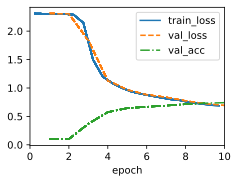

In [76]:
trainer = d2l.Trainer(max_epochs=10, num_gpus=1)
data = d2l.FashionMNIST(batch_size=128)
model = LeNet()
model.apply_init([next(iter(data.get_dataloader(True)))[0]], init_cnn)
trainer.fit(model, data)